In [1]:
import os
import psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss)  # in bytes 

51720192


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import time

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

TRAFFIC_DIRECTION = 'received'


np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
import requests
import json

# Fetch data from netdata
vim_endpoint = "vimdemo1.cs.upb.de"
chart_id = "cgroup_qemu_qemu_127_instance_0000007f.net_tap0c32c278_4e"
# 7 days = 604800
avg_sec = 604800
group_time = 50
_c_name = chart_id.split(".")[1]

# http://vimdemo1.cs.upb.de:19999/api/v1/data?chart=cgroup_qemu_qemu_127_instance_0000007f.net_tap0c32c278_4e&gtime=60
_chart_avg_url = "http://{host}:19999/api/v1/data?chart={chart_id}&format=json&after=-{last_sec_avg}&gtime={gtime}&options=flip"

r = requests.get(_chart_avg_url.format(host=vim_endpoint, chart_id=chart_id, 
                                           last_sec_avg=avg_sec, gtime=group_time), verify=False)

_instance_metrics = {}

if r.status_code == requests.codes.ok:
    _result_json = json.loads(r.text)
    if "net" in _c_name:
        if "packets" in _c_name:
            _instance_metrics["packets"] = _result_json
        else:
            _instance_metrics["net"] = _result_json
    else:
        _instance_metrics[_c_name] = _result_json

# _result_json


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

train = pd.DataFrame(_result_json['data'], columns=_result_json['labels'])

train = train.set_index("time")



traffic_training_complete = train
traffic_training_processed_complete = traffic_training_complete[[TRAFFIC_DIRECTION]]
traffic_training_scaled_complete = scaler.fit_transform(traffic_training_processed_complete)

train.head()

,received,sent
time,,
1587388400,49.368000,0.0
1587388350,72.736317,0.0
1587388300,64.303592,0.0
1587388250,80.588189,0.0
1587388200,57.771901,0.0


In [5]:
# plt.plot(time, sin, label='sine (with noise)');
# plt.legend();
traffic_training_scaled_complete

array([[0.16950027],
       [0.27776639],
       [0.23869732],
       ...,
       [0.0825105 ],
       [0.21167641],
       [0.17172721]])

# Data Preprocessing

In [6]:
df = pd.DataFrame(traffic_training_scaled_complete, columns=[TRAFFIC_DIRECTION])
df.head(5)

df_original = pd.DataFrame(traffic_training_processed_complete, columns=[TRAFFIC_DIRECTION])
df_original.head(5)

,received
time,
1587388400,49.368000
1587388350,72.736317
1587388300,64.303592
1587388250,80.588189
1587388200,57.771901


In [7]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

train_original, test_original = df_original.iloc[0:train_size], df_original.iloc[train_size:len(df_original)]

test.head()

1740 436


,received
1740,0.081751
1741,0.178303
1742,0.166431
1743,0.356394
1744,0.240631


In [8]:
# multi-step data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = np.array(train[TRAFFIC_DIRECTION])
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# split into samples
X_train, y_train = split_sequence(raw_seq, n_steps_in, n_steps_out)

# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))



# define input sequence
raw_seq_test = np.array(test[TRAFFIC_DIRECTION])
X_test, y_test = split_sequence(raw_seq_test, n_steps_in, n_steps_out)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_test.shape)


(432, 3, 1)


# Modeling

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Dense(1))

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = n_steps_out))

# model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Training

In [10]:
start_time = time.time()
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1
)

print("Time taken: ", time.time()-start_time)


Train on 1562 samples, validate on 174 samples
Epoch 1/5
1562/1562 [==============================] - 9s 6ms/sample - loss: 0.0148 - val_loss: 0.0046
Epoch 2/5
1562/1562 [==============================] - 1s 866us/sample - loss: 0.0088 - val_loss: 0.0046
Epoch 3/5
1562/1562 [==============================] - 1s 834us/sample - loss: 0.0087 - val_loss: 0.0050
Epoch 4/5
1562/1562 [==============================] - 1s 893us/sample - loss: 0.0088 - val_loss: 0.0047
Epoch 5/5
1562/1562 [==============================] - 1s 829us/sample - loss: 0.0087 - val_loss: 0.0047
Time taken:  14.386230707168579


## Evaluation

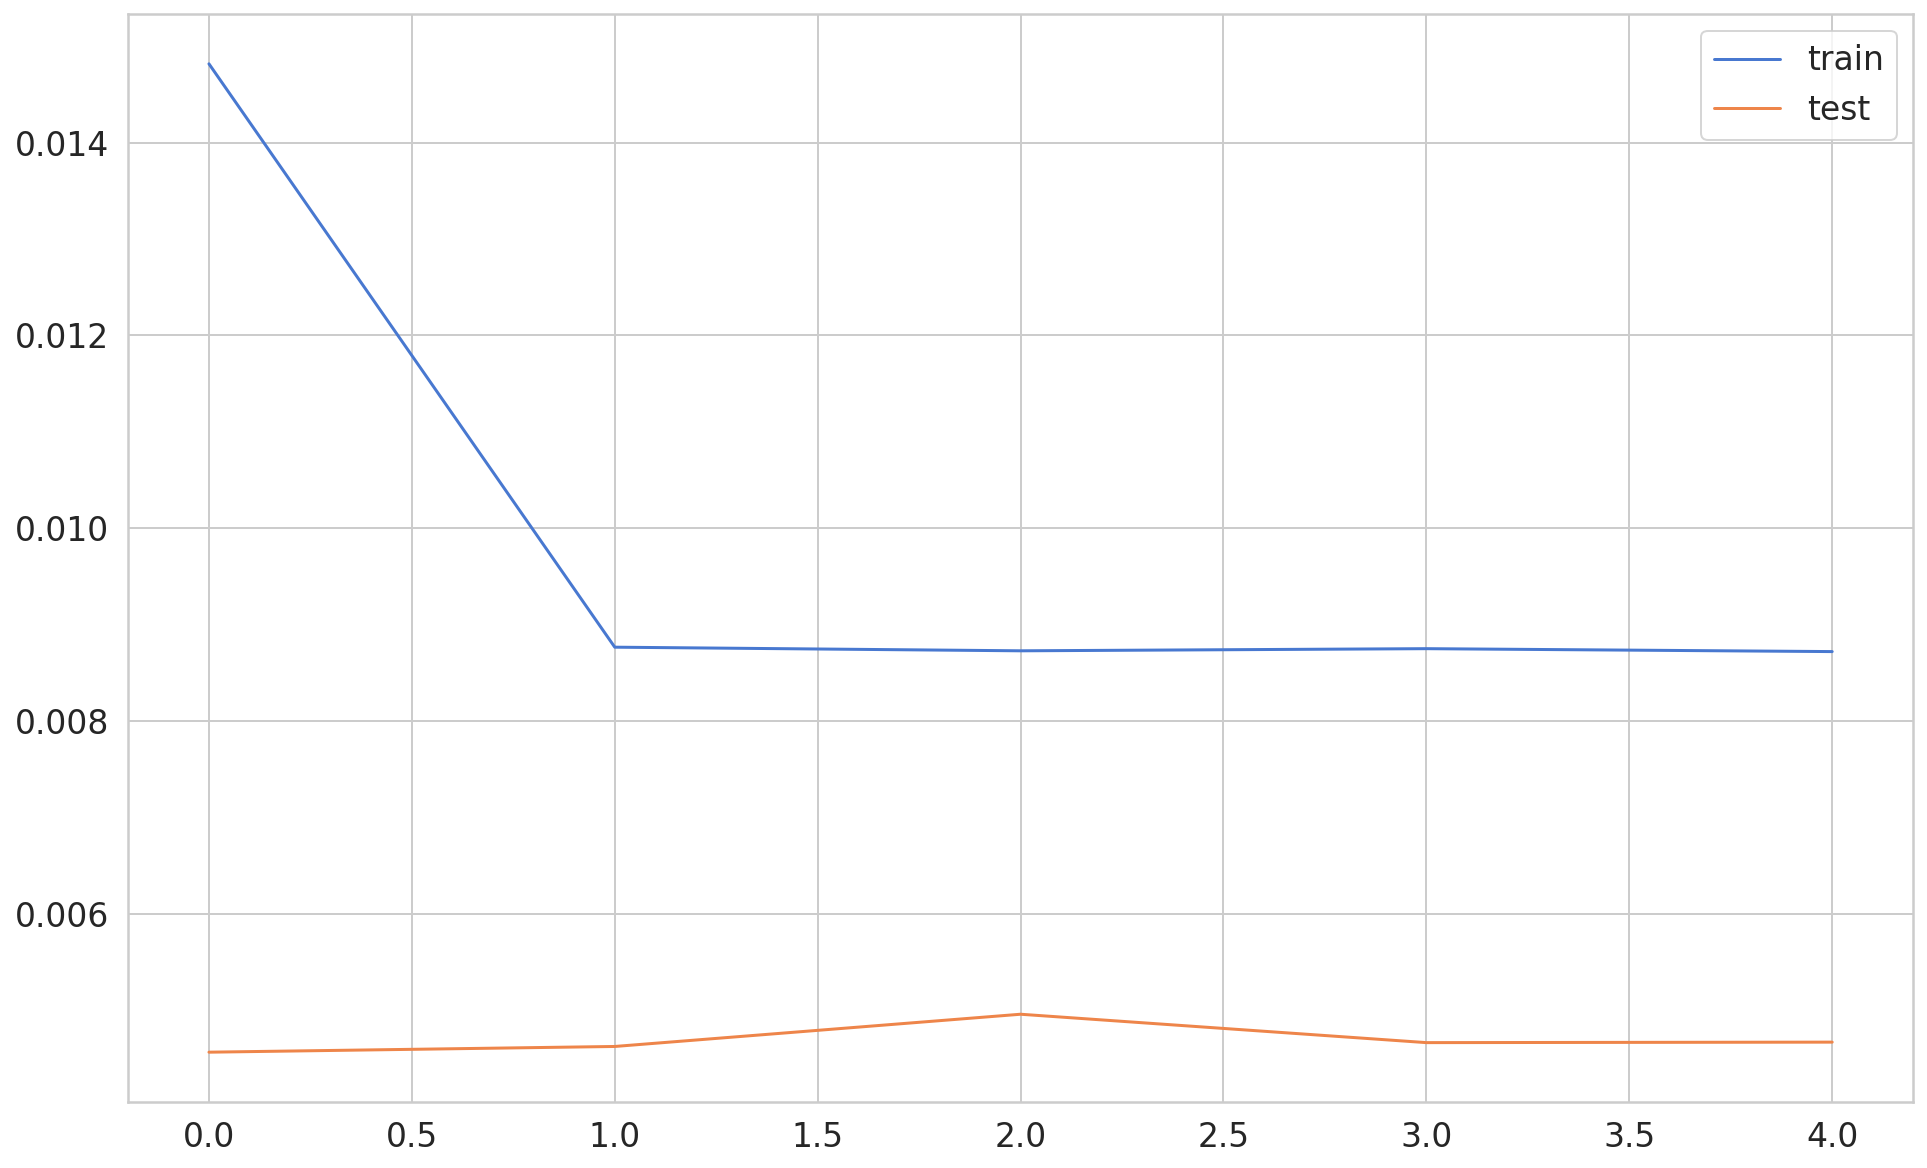

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [12]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

y_test = np.reshape(y_test, (y_test.shape[0], n_steps_out))
y_test.shape

y_train = np.reshape(y_train, (y_train.shape[0], n_steps_out))
y_train.shape

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [18]:
# y_pred

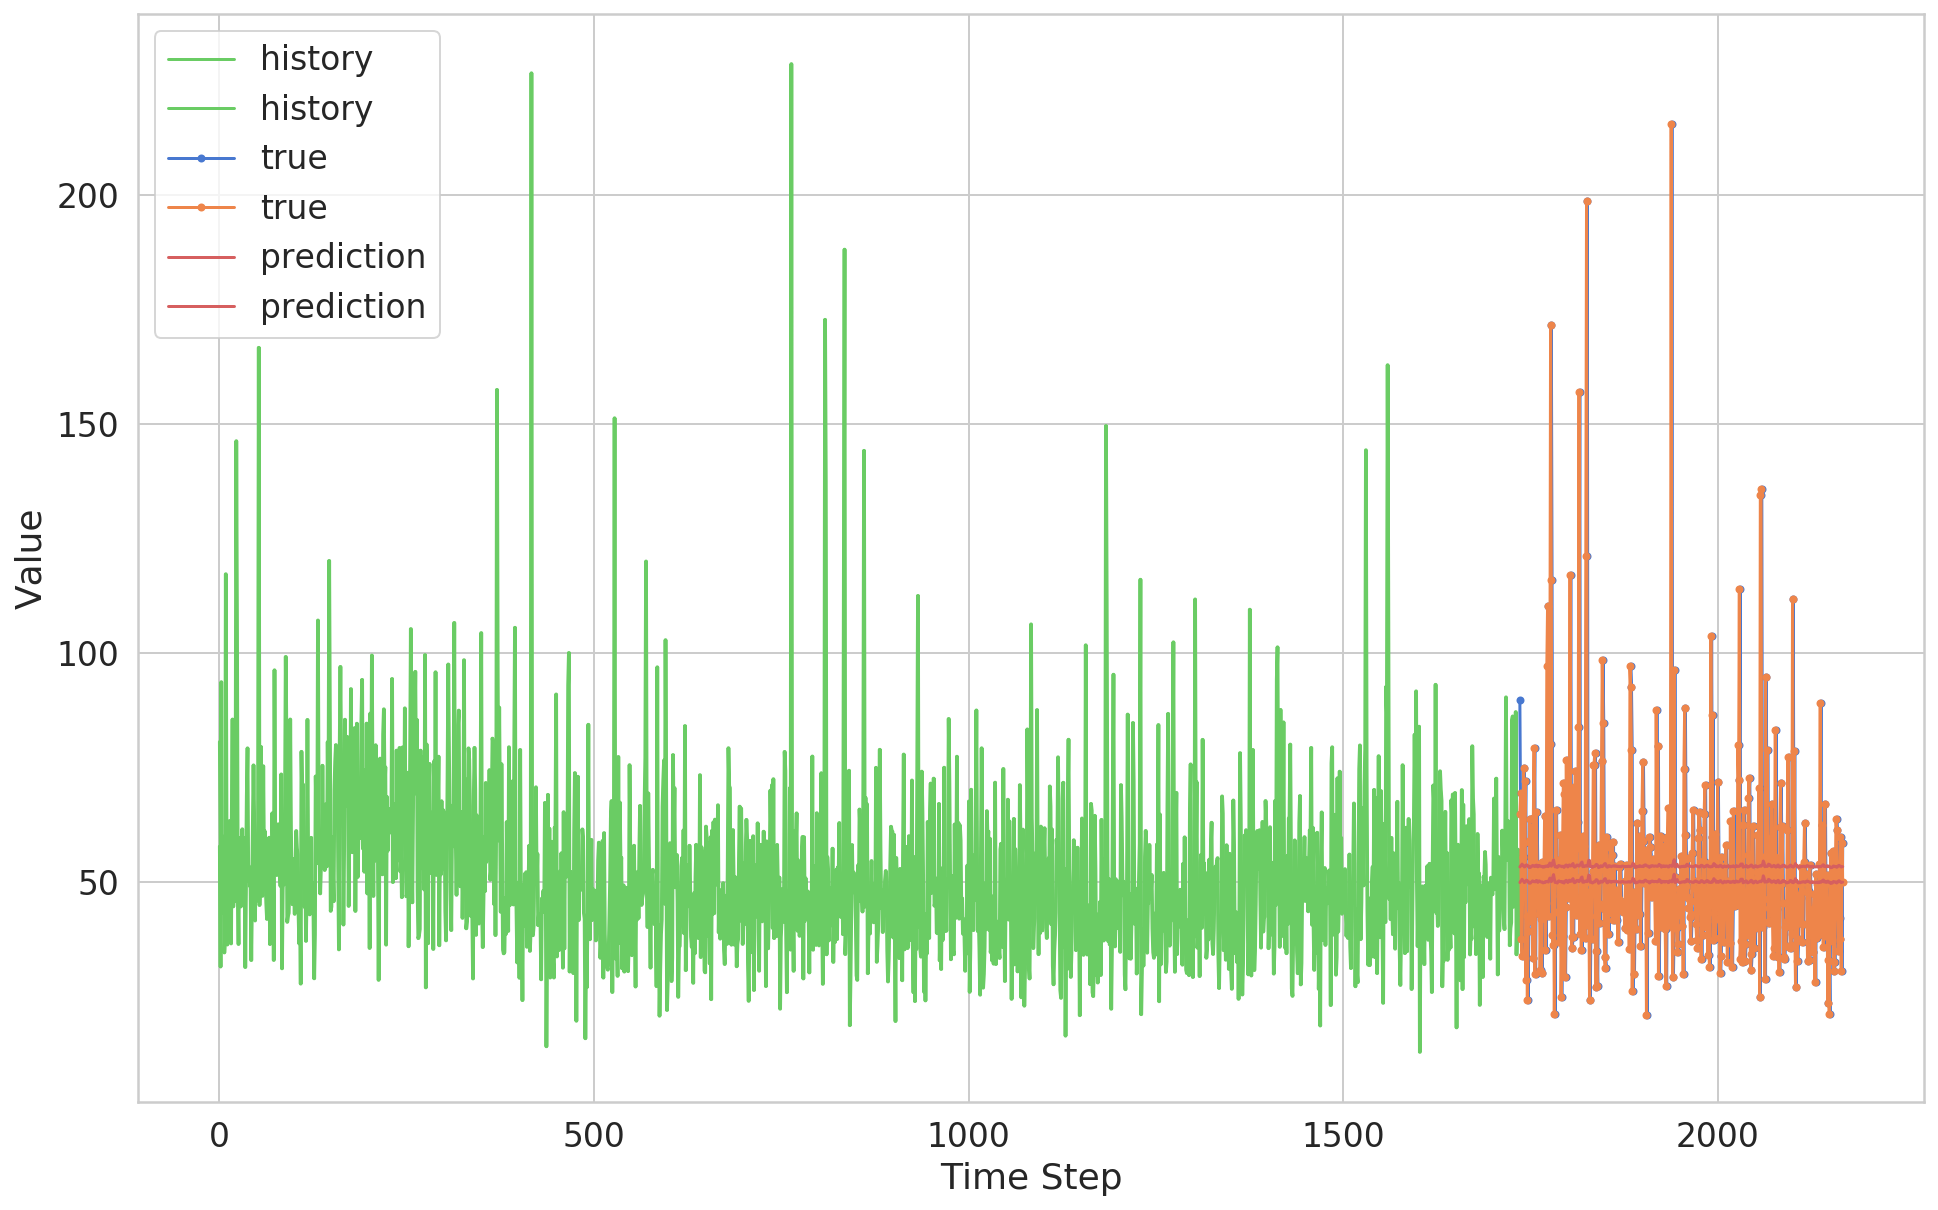

In [14]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

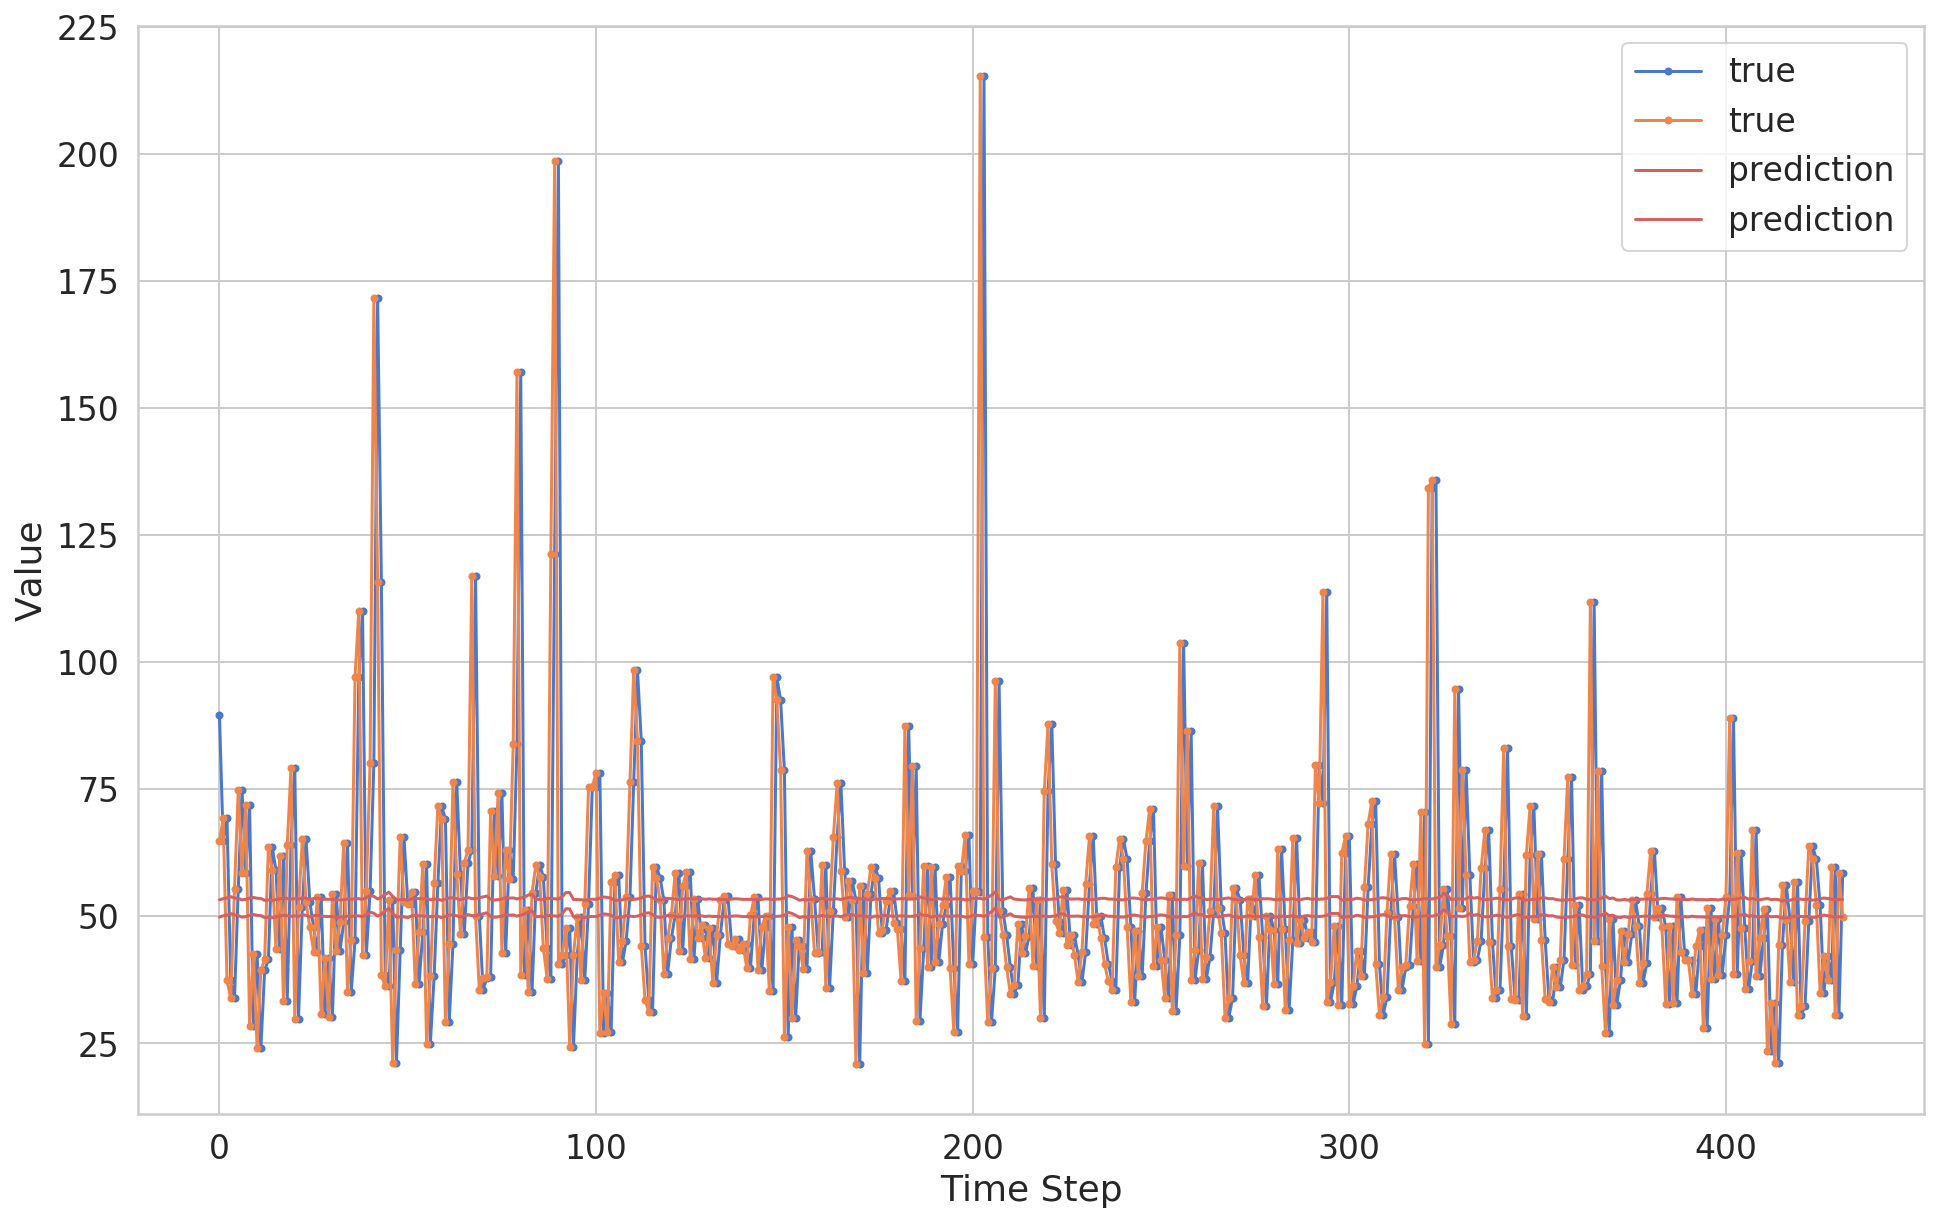

In [15]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Save and Load Model

In [16]:
scores = model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# save model and architecture to single file
model.save("model.h5")

print(scores)
model.summary()

3163.2573603877313
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 3, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5

In [17]:
# load and evaluate a saved model
from tensorflow.keras.models import load_model

# load model
model = load_model('model.h5')

# summarize model.
# model.summary()

# load dataset
scores = model.evaluate(X_test, y_test, verbose=0)

print(scores)

3163.2573603877313


# Iterative Training

In [21]:
from tensorflow.keras.models import load_model

# load model
model = load_model('model.h5')

start_time = time.time()
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    verbose=1
)

print("Time taken: ", time.time()-start_time)


Train on 1562 samples, validate on 174 samples
Epoch 1/5
1562/1562 [==============================] - 5s 3ms/sample - loss: 2347.2736 - val_loss: 1452.1544
Epoch 2/5
1562/1562 [==============================] - 1s 896us/sample - loss: 1589.6867 - val_loss: 1110.0035
Epoch 3/5
1562/1562 [==============================] - 1s 913us/sample - loss: 1302.5527 - val_loss: 895.8134
Epoch 4/5
1562/1562 [==============================] - 1s 890us/sample - loss: 1105.7599 - val_loss: 740.3711
Epoch 5/5
1562/1562 [==============================] - 1s 922us/sample - loss: 959.7845 - val_loss: 622.3608
Time taken:  10.899009704589844
